<a href="https://colab.research.google.com/github/daotrananhtuan09102002/CS331.N12.KHCL/blob/main/Training_mobilenetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [ ]:
dataset_dir = '../input/augmentation-utk/augmentation_utk'
batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=159,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=159,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51654 files belonging to 18 classes.
Using 41324 files for training.


2022-11-19 14:53:20.933074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 14:53:21.082001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 14:53:21.083071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 14:53:21.086400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 51654 files belonging to 18 classes.
Using 10330 files for validation.


# Visualize some images

In [ ]:
class_names = train_ds.class_names
print(class_names)

['1-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']


2022-11-18 06:33:25.801735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


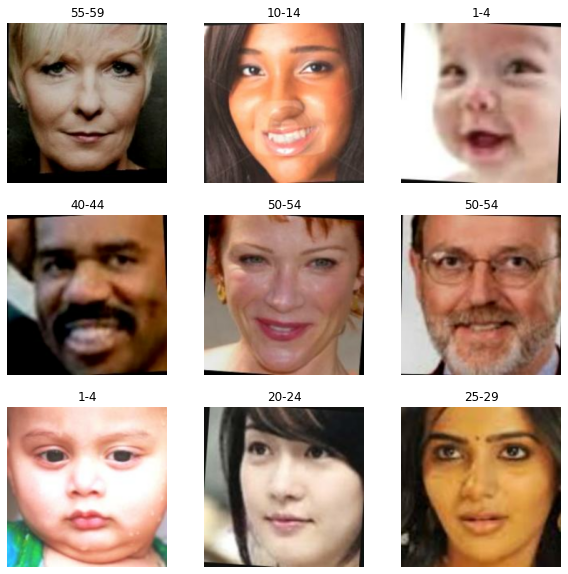

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
from sklearn.utils import class_weight
import os
from itertools import chain
import numpy as np

y_train = []

for folder in os.listdir('../input/augmentation-utk/augmentation_utk/'):
    y_train.append([folder] * len(os.listdir('../input/augmentation-utk/augmentation_utk/' + folder)))

y_train = list(chain.from_iterable(y_train))

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6651985782722918,
 1: 1.6674414100329267,
 2: 1.0274495763217568,
 3: 0.6304188635032221,
 4: 0.5700569460998544,
 5: 0.6304188635032221,
 6: 0.6425585908344529,
 7: 0.8127065042952893,
 8: 0.9058291245791246,
 9: 1.078416635350119,
 10: 0.7143805493320057,
 11: 1.01222810111699,
 12: 1.3193869731800767,
 13: 1.6370032325537174,
 14: 2.5783168613357295,
 15: 2.961472308221534,
 16: 4.087844254510921,
 17: 2.2108371854134568}

# Load batch

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2022-11-19 14:53:33.081423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 224, 224, 3)
(64, 18)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

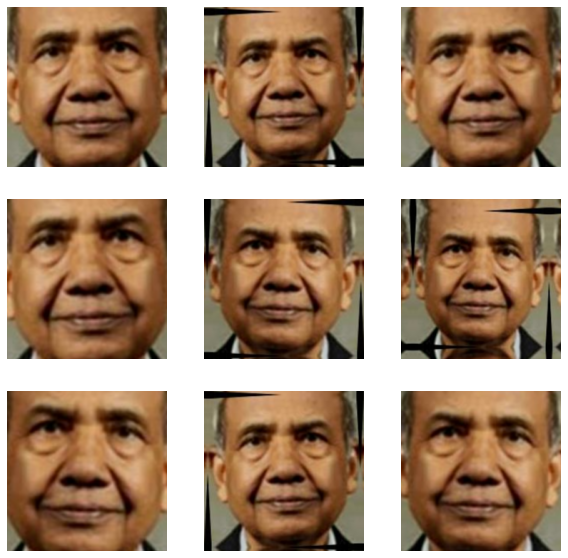

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Create model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import regularizers

In [ ]:
test = tf.keras.applications.MobileNetV3Large(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [ ]:
test.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_4[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [ ]:
tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet', 
    input_shape=(224,224,3)
).summary()

17620992/17605208 [==============================] - 1s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
__________________

In [ ]:
# def create_model(input_shape, n_classes, lr=1e-5, fine_tune = 0):
#     """
#     Compiles a model integrated with VGG16 pretrained layers
    
#     input_shape: tuple - the shape of input images (width, height, channels)
#     n_classes: int - number of classes for the output layer
#     optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
#     fine_tune: int - The number of pre-trained layers to unfreeze.
#                 If set to 0, all pretrained layers will freeze during training
#     """

#     if fine_tune:
#         conv_base.trainable = True
#     else:
#         inputs = tf.keras.Input(shape=input_shape)
#         x = data_augmentation(inputs)
#         x = tf.keras.applications.inception_v3.preprocess_input(x)
        
#         conv_base = keras.applications.inception_v3.InceptionV3(include_top=False,
#                                                             weights='imagenet', 
#                                                             input_shape=input_shape,
#                                                             input_tensor=x)

#         # Pretrained convolutional layers are loaded using the Imagenet weights.
#         # Include_top is set to False, in order to exclude the model's fully-connected layers.
        
#         conv_base.trainable = False

#         # Defines how many layers to freeze during training.
#         # Layers in the convolutional base are switched from trainable to non-trainable
#         # depending on the size of the fine-tuning parameter.


#         x = GlobalAveragePooling2D(name="avg_pool")(conv_base.output)
#         x = BatchNormalization()(x)
#         x = Dropout(0.3)(x)
#         x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
#         x = Dropout(0.3)(x)
#         predictions = Dense(18, activation='softmax')(x)

#         # Group the convolutional base and new fully-connected layers into a Model object.
#         model = Model(inputs=inputs, outputs=predictions, name='InceptionV3')

#     # Compiles the model for training.
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
#                   loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#                   metrics=['accuracy'])
    
#     return model

In [ ]:
base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet', 
    input_shape=(224,224,3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = Dropout(0.2)(x)
x = Conv2D(filters=18, kernel_size=(1, 1), padding="same", name='Logits')(x)
x = Flatten()(x)
outputs = Dense(18, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name='MobileNetV3Large')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)
model.summary()

Model: "MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1280)        0         
_________________________________________________________________
Logits (Conv2D)              (None, 1, 1, 18)          23058     
_________________________________________________________________
flatten_6 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                342       
Total params: 4,249,832
Trainable params: 23,400
Non-trainable params: 4,226,432
___________________________________

In [ ]:
print('Number of layers: ', len(model.layers))
for i, layer in enumerate(model.layers):
    if layer.trainable:
        print(i, layer)

Number of layers:  6
0 <keras.engine.input_layer.InputLayer object at 0x7fb7eec13310>
2 <keras.layers.core.Dropout object at 0x7fb7edcd3ad0>
3 <keras.layers.convolutional.Conv2D object at 0x7fb7eeef29d0>
4 <keras.layers.core.Flatten object at 0x7fb7ed838990>
5 <keras.layers.core.Dense object at 0x7fb7edcd3050>


# Create callback

In [ ]:
import time

In [ ]:
weights_path = './MobileNetV3Large'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.025,
                                                 patience = 3,
                                                 factor = 0.1,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 1e-9)

cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.025,
    verbose=1,
    mode='auto')

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{weights_path}/model.ckpt', 
    monitor='val_accuracy', 
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
csv_logger = tf.keras.callbacks.CSVLogger(f'{weights_path}/training.log', append=True)

# Training model

In [ ]:
# Training model from checkpoint
model.load_weights( f'{weights_path}/model.ckpt')

In [ ]:
model.summary()

Model: "MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1280)        0         
_________________________________________________________________
Logits (Conv2D)              (None, 1, 1, 18)          23058     
_________________________________________________________________
flatten_6 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                342       
Total params: 4,249,832
Trainable params: 23,400
Non-trainable params: 4,226,432
___________________________________

In [ ]:
start = time.time()
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=500,
                    class_weight=class_weights,
                    verbose=1,
                    callbacks=[cb_early_stopping, cb_checkpoint, reduce_lr, csv_logger])

print('Training time = {:.2f}s'.format((time.time()-start)))

Epoch 1/500


2022-11-19 15:31:30.936369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


646/646 [==============================] - 154s 221ms/step - loss: 2.6982 - accuracy: 0.1891 - val_loss: 2.4055 - val_accuracy: 0.2771

Epoch 00001: val_accuracy improved from -inf to 0.27706, saving model to ./MobileNetV3Large/model.ckpt
Epoch 2/500
646/646 [==============================] - 76s 116ms/step - loss: 2.4573 - accuracy: 0.2691 - val_loss: 2.3058 - val_accuracy: 0.2999

Epoch 00002: val_accuracy improved from 0.27706 to 0.29990, saving model to ./MobileNetV3Large/model.ckpt
Epoch 3/500
646/646 [==============================] - 74s 114ms/step - loss: 2.3777 - accuracy: 0.2905 - val_loss: 2.2585 - val_accuracy: 0.3099

Epoch 00003: val_accuracy improved from 0.29990 to 0.30987, saving model to ./MobileNetV3Large/model.ckpt
Epoch 4/500
646/646 [==============================] - 75s 115ms/step - loss: 2.3234 - accuracy: 0.3034 - val_loss: 2.2263 - val_accuracy: 0.3232

Epoch 00004: val_accuracy improved from 0.30987 to 0.32323, saving model to ./MobileNetV3Large/model.ckpt
Ep

In [ ]:
!ls InceptionV3

In [ ]:
!rm -r InceptionV3/*
!ls InceptionV3

# Fine tuning

In [ ]:
# model = create_model((224,224,3), 18, 1e-4)
# model.load_weights( f'{weights_path}/model.ckpt')
# model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_3 (TFOpLambda)  (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract_3 (TFOpLambda) (None, 224, 224, 3)  0           tf.math.truediv_3[0][0]          
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         tf.math.subtract_3[0][0]         
________________________________________________________________________________________

In [ ]:
# def unfreeze_model(model, n, lr):
#     for layer in model.layers[-n:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
#                   loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#                   metrics=['accuracy'])

In [ ]:
base_model.trainable = True
for i, layer in enumerate(model.layers):
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

Model: "MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1280)        0         
_________________________________________________________________
Logits (Conv2D)              (None, 1, 1, 18)          23058     
_________________________________________________________________
flatten_6 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                342       
Total params: 4,249,832
Trainable params: 4,225,432
Non-trainable params: 24,400
___________________________________

In [ ]:
print('Number of layers: ', len(model.layers))
for i, layer in enumerate(model.layers):
    if not layer.trainable:
        print(i, layer)

Number of layers:  11
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0f16af2490>


In [ ]:
weights_path = './MobileNetV3Large/Fine_tuning'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.025,
                                                 patience = 2,
                                                 factor = 0.1,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 1e-9)

cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.025,
    verbose=1,
    mode='auto')

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{weights_path}/model.ckpt', 
    monitor='val_accuracy', 
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
csv_logger = tf.keras.callbacks.CSVLogger(f'{weights_path}/training.log', append=True)

In [ ]:
start = time.time()
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=500,
                    class_weight=class_weights,
                    callbacks=[cb_early_stopping, cb_checkpoint, reduce_lr, csv_logger])

print('Training time = {:.2f}s'.format((time.time()-start)))

Epoch 1/500
646/646 [==============================] - 225s 338ms/step - loss: 2.0454 - accuracy: 0.3880 - val_loss: 1.8483 - val_accuracy: 0.4398

Epoch 00001: val_accuracy improved from -inf to 0.43979, saving model to ./MobileNetV3Large/Fine_tuning/model.ckpt
Epoch 2/500
646/646 [==============================] - 217s 336ms/step - loss: 1.7624 - accuracy: 0.4774 - val_loss: 1.7327 - val_accuracy: 0.4892

Epoch 00002: val_accuracy improved from 0.43979 to 0.48916, saving model to ./MobileNetV3Large/Fine_tuning/model.ckpt
Epoch 3/500
646/646 [==============================] - 217s 335ms/step - loss: 1.5154 - accuracy: 0.5664 - val_loss: 1.6374 - val_accuracy: 0.5314

Epoch 00003: val_accuracy improved from 0.48916 to 0.53136, saving model to ./MobileNetV3Large/Fine_tuning/model.ckpt
Epoch 4/500
646/646 [==============================] - 214s 330ms/step - loss: 1.3152 - accuracy: 0.6487 - val_loss: 1.5904 - val_accuracy: 0.5645

Epoch 00004: val_accuracy improved from 0.53136 to 0.5644

# Plot history when complete

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

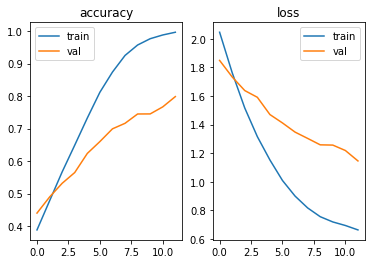

In [ ]:
his = pd.read_csv(f'/content/train.csv')

plt.subplot(121)
plt.title('accuracy')
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
plt.legend(['train', 'val'])

plt.subplot(122)
plt.title('loss')
plt.plot(his['loss'],)
plt.plot(his['val_loss'])
plt.legend(['train', 'val'])

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load best weight to evaluate

In [ ]:
model.load_weights( f'{weights_path}/model.ckpt')

In [ ]:
model.evaluate(validation_dataset)

162/162 [==============================] - 20s 119ms/step - loss: 0.9273 - accuracy: 0.7606


[0.9273126721382141, 0.760600209236145]

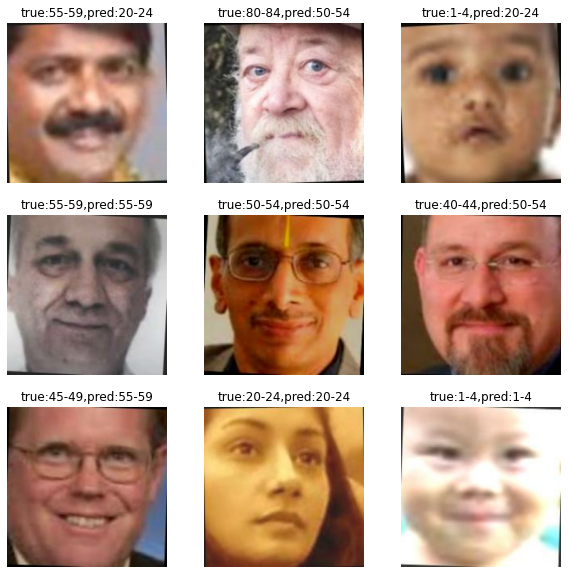

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        i_i = images[i].numpy().astype("uint8").reshape(1, 224, 224, 3)
        y_i = preprocess_input(i_i)
        y_pred = class_names[np.argmax(model.predict(y_i))]
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'true:{class_names[np.argmax(labels[i])]},pred:{y_pred}')
        plt.axis("off")

# Confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
y_true = tf.argmax(correct_labels, axis=1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

In [ ]:
print(classification_report(y_true, predicted_labels, target_names=sorted(class_names, key=lambda x: int(x.replace('+', '-').split('-')[0]))))

              precision    recall  f1-score   support

         1-4       0.98      0.97      0.97       851
         5-9       0.87      0.91      0.89       367
       10-14       0.87      0.83      0.85       568
       15-19       0.78      0.74      0.76       897
       20-24       0.83      0.90      0.86      1032
       25-29       0.62      0.62      0.62       917
       30-34       0.65      0.63      0.64       875
       35-39       0.77      0.77      0.77       693
       40-44       0.78      0.76      0.77       669
       45-49       0.91      0.90      0.90       515
       50-54       0.82      0.83      0.83       779
       55-59       0.86      0.82      0.84       597
       60-64       0.83      0.85      0.84       439
       65-69       0.82      0.87      0.84       336
       70-74       0.86      0.88      0.87       226
       75-79       0.91      0.91      0.91       185
       80-84       0.90      0.85      0.88       130
         85+       0.92    

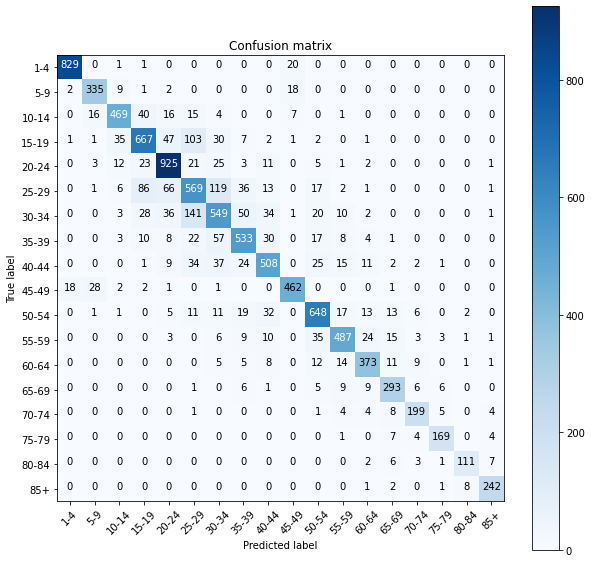

In [ ]:
cnf_matrix = confusion_matrix(y_true, predicted_labels)
plot_confusion_matrix(cnf_matrix, classes=sorted(class_names, key=lambda x: int(x.replace('+', '-').split('-')[0])),
                      title='Confusion matrix')
plt.show();

# Testing on one image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Text(0.5, 1.0, 'pred:50-54')

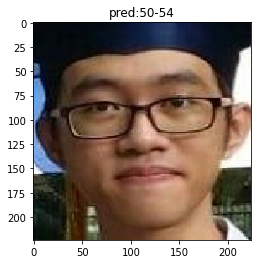

In [ ]:
# load an image from file
image = load_img('../input/inference-image/Vinh_Troll.jpg', target_size=(224, 224))
plt.imshow(image)
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# y_i = tf.keras.applications.inception_v3.preprocess_input(image)
y_pred = class_names[np.argmax(model.predict(image))]
plt.title(f'pred:{y_pred}')

# Save model and weight to download

In [ ]:
!pip install pyyaml h5py

In [ ]:
model.save('MobileNetV3Large_0.81valacc')

In [ ]:
model.summary()

Model: "MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1280)        0         
_________________________________________________________________
Logits (Conv2D)              (None, 1, 1, 18)          23058     
_________________________________________________________________
flatten_6 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                342       
Total params: 4,249,832
Trainable params: 4,225,432
Non-trainable params: 24,400
___________________________________

In [ ]:
!ls 

InceptionV3  InceptionV3_0.73valacc  __notebook_source__.ipynb


In [ ]:
!cp ./weights_v8/training.log  ./InceptionV3_0.73valacc

In [ ]:
!ls ./resnet_model_76valacc

assets	keras_metadata.pb  saved_model.pb  training.log  variables


In [ ]:
# !rm -r ./weight.tar.gz

In [ ]:
!7z a  ./MobileNetV3Large_0.81valacc/*


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan  ./MobileNetV3Large_0.81valacc                                        1 folder, 4 files, 57387997 bytes (55 MiB)

Creating archive: ./MobileNetV3Large_0.81valacc/assets.7z

Items to compress: 5

      2% 1 + saved_model.p                        5% 1 + saved_model.p                        8% 1 + saved_model.p                       11% 2 + variables/variables.data-00000-of-000                                               13% 2 + variables/variables.data-00000-of-000                                               15% 2 + variables/variables.data-00000-of-000                                               18% 2 + variables/variables.data-00000-of-000                                               20% 2 + variables/variables.data-00000-of-000                               

In [ ]:
from IPython.display import FileLink
FileLink(r'./MobileNetV3Large_0.81valacc/assets.7z')

/kaggle/working/MobileNetV3Large_0.81valacc/assets.7z